# Use Case: Retrieving and Displaying Hydrometric Data

## Introduction

Hydrometric data from the Meteorological Service of Canada (MSC), Environment and Climate Change Canada (ECCC) can be easily accessed via [GeoMet-OGC-API](https://api.weather.gc.ca/). The [OGC API - Features](https://eccc-msc.github.io/open-data/msc-geomet/web-services_en/#ogc-api-features) web services available in GeoMet-OGC-API offer the capability to query vector geospatial data and retrieve it in a GeoJSON format. The GeoJSON output file can then be used for display or further data processing. This use case will show you how you can:
* Query and retrieve vector geospatial data from GeoMet-OGC-API with [Python](https://www.python.org/)
* Display time series data in graphic and tabular format
* Create an interactive map to display geospatial data

[![badge](https://img.shields.io/badge/Executable%20version-binder-F5A252.svg?logo=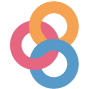)](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case-quantiles/main?filepath=docs%2Fuse-case-oafeat-en-quartiles.ipynb)

To run the entire notebook, click on the ⏩️ symbol or select the Cell -> Run All option in the menu bar.

## Creation of a tool to monitor water levels

Cathy runs a boat tours and water sports company in Chilliwack, British-Columbia. She would like to track the water levels of a few hydrometric stations near her city to guide the management of the company's activities. She would like to have:
* An overview of the distribution of the daily water level of a three months period for all hydrometric stations located within 50 km of the city of Chilliwack (minimum, first quartile, median, third quartile and maximum) 
* A graphic view that presents the provisional daily mean water level of a three months period with a color code to indicate the water level status
* A tabular view that shows the provisional daily mean water level of a three months period with the same color code
* A web map that displays the hydrometric stations located within 50 km of the city of Chilliwack and the most recent provisional daily mean water level of these stations for the selected time period with the appropriate color code

To achieve this, the first step is to import the necessary Python modules and to select the desired request parameters.

In [1]:
# Modules importation
from datetime import date, datetime
import json

from ipyleaflet import (
    AwesomeIcon,
    basemaps,
    FullScreenControl,
    LegendControl,
    Map,
    Marker,
    ScaleControl,
    WidgetControl,
)
from ipywidgets import HTML, interactive, interact
from osgeo import ogr, osr
from owslib.ogcapi.features import Features
import numpy as np
import pandas as pd

In [2]:
# Parameters

# Coordinates of Chilliwack
lat = 49.162676
long = -121.958943

# Buffer size in kilometres
buffer = 50

# Start and end of the time period for which the data will be retrieved
start_date = date(2018, 6, 1)
end_date = date(2018, 8, 31)

# Number of year of data to use to calculate daily water level quantiles
year_hist = 10

# Prefered projection
# NAD83 / Statistics Canada Lambert
projection = 3347

In [3]:
# Parameters formatting for the OGC API - Features request

# Bounding box a little bigger than buffer size

# The buffer needs to be transformed in degrees to get
# the coordinates of the corners of the bounding box:
# Latitude: 1 km ≈ 0.009° 
# Longitude (at the 49th parallel): 1 km ≈ 0.014°
bbox = [
    str(long - buffer * 0.02),
    str(lat - buffer * 0.01),
    str(long + buffer * 0.02),
    str(lat + buffer * 0.01),
]

# Formatting of the selected time period
time = f"{start_date}/{end_date}"

Then, the [hydrometric monitoring stations data](https://geo.weather.gc.ca/geomet/features/collections/hydrometric-stations) available on GeoMet-OGC-API can be retrieved with the [OWSLib package](https://geopython.github.io/OWSLib/). As the bounding box parameter is not as precise as a round buffer, [GDAL](https://gdal.org/api/index.html#python-api) can be used to select only the hydrometric stations that are strictly inside a 50 km radius from Chilliwack.

In [4]:
# Retrieval of hydrometric stations data
oafeat = Features("https://api.weather.gc.ca/")
station_data = oafeat.collection_items(
    "hydrometric-stations", bbox=bbox, STATUS_EN="Active"
)

# Verification of the retrieved data
if "features" in station_data.keys() and station_data["features"]:
    station_data = json.dumps(station_data, indent=4)
else:
    raise ValueError(
        "No hydrometric stations were found. Please verify the coordinates."
    )

In [5]:
# List of stations located inside the buffer zone

# Accessing the hydrometric station layer
driver = ogr.GetDriverByName("GeoJSON")
data_source = driver.Open(station_data, 0)
layer = data_source.GetLayer()

# Identification of the input spatial reference system
srs_input = layer.GetSpatialRef()
sr = osr.SpatialReference(str(srs_input))
epsg = sr.GetAuthorityCode(None)
srs_input.ImportFromEPSG(int(epsg))

# Definition of the spatial reference system used to project data
srs_projected = osr.SpatialReference()
srs_projected.ImportFromEPSG(projection)

# Transformation from input srs to the prefered projection
transform = osr.CoordinateTransformation(srs_input, srs_projected)

# Creation of a buffer to select stations
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(long, lat)
point.Transform(transform)
point_buffer = point.Buffer(buffer * 1000)  # The value must be in meters

# Selection of the stations in the buffer zone
stations = []

for feature in layer:
    geom = feature.GetGeometryRef().Clone()
    geom.Transform(transform)
    if geom.Intersects(point_buffer):
        stations.append(feature.STATION_NUMBER)

if not stations:
    raise ValueError(
        f"There are no hydrometric stations within {buffer} km" + 
        " of the chosen coordinates. Please verify the coordinates."
    )

Once the hydrometric monitoring stations located within 50 km of Chilliwack are identified, the water level data for a three months period can be retrieved for each station. A water level status will be attributed to each daily mean according to which quartile of the historical daily water level the value is part of.

|Quartile|Water level status|Color|
|---|---|---|
|Upper quartile|High|Red|
|Between the upper quartile<br>and the lower quartile|Medium|Blue|
|Lower quartile|Low|Green|

The daily mean water levels of the three months period will be used to create a data frame for each station with [Pandas](https://pandas.pydata.org/). To facilitate the data manipulations, all the data frames will be gathered in a Python dictionary. These data frames will be used to create interactive graphic and tabular views of the historical daily mean water levels of the hydrometric monitoring stations located within 50 km of Chilliwack. They will also be used to display the hydrometric stations on a map with their most recent daily mean water level data for the time period.

Stations that are missing water level data in the desired time period will be removed from the dataset.

In [6]:
# Retrieval of hydrometric data for each station

# Function to associate a status to each water level
def level_status(row, df):
    df_grouped = df["LEVEL"].groupby(df.index.strftime('%m-%d'))
    if np.isnan(df_grouped.mean().xs(row.name.strftime('%m-%d'))):
        return np.nan
    if row["LEVEL"] < df_grouped.quantile(0.25).xs(row.name.strftime('%m-%d')):
        status = "Low"
    elif row["LEVEL"] > df_grouped.quantile(0.75).xs(row.name.strftime('%m-%d')):
        status = "High"
    else:
        status = "Medium"
    return status


def level_extremum(row, df, type_extremum):
    df_grouped = df["LEVEL"].groupby(df.index.strftime('%m-%d'))
    if type_extremum == "min":
        extremum = df_grouped.min().xs(row.name.strftime('%m-%d'))
    elif type_extremum == "max":
        extremum = df_grouped.max().xs(row.name.strftime('%m-%d'))
    return extremum


# Dictionary that will contain a data frame for each station with the
# historical daily water level for the time period
hydrometric_data = {}

# List of stations with missing data
stations_without_data = []

# Data retrieval and creation of the data frames
for station in stations:

    # Retrieval of water level data
    historical_data = []
    for year in range(end_date.year - year_hist + 1, end_date.year + 1):
        start = date(year, start_date.month, start_date.day)
        end = date(year, end_date.month, end_date.day)
        # Retrieval of water level data
        hydro_data = oafeat.collection_items(
            "hydrometric-daily-mean", 
            bbox=bbox, datetime="{}/{}".format(start, end), 
            STATION_NUMBER=station
        )
        if 'features' in hydro_data.keys() and hydro_data["features"]:
            historical_data.extend(hydro_data["features"])

    # Creation of a dataframe if there is data for the whole time period
    if historical_data:
        historical_data_format = [{
            "LATITUDE": el["geometry"]["coordinates"][1], 
            "LONGITUDE": el["geometry"]["coordinates"][0], 
            **el["properties"
        ]} for el in historical_data]
        historical_data_df = pd.DataFrame(historical_data_format, columns=[
            "STATION_NUMBER", 
            "STATION_NAME", 
            "DATE", 
            "LEVEL", 
            "LATITUDE", 
            "LONGITUDE"
        ])
        historical_data_df = historical_data_df.fillna(value=np.nan)
        historical_data_df["DATE"] = pd.to_datetime(
                historical_data_df["DATE"]
            )
        selected_period_data = historical_data_df[
            (historical_data_df["DATE"] > pd.to_datetime(start_date)) 
            & (historical_data_df["DATE"] < pd.to_datetime(end_date))
        ]
        if selected_period_data["LEVEL"].isnull().all():
            stations_without_data.append(station)
        else:
            # Removing any rows without water level data at the
            # end of the data frame
            while np.isnan(historical_data_df["LEVEL"].iloc[-1]):
                historical_data_df = historical_data_df.drop(
                    historical_data_df.tail(1).index
                )
            historical_data_df.set_index(["DATE"], inplace=True, drop=True)
            historical_data_df["STATUS"] = historical_data_df.apply(
                level_status, df=historical_data_df, axis=1
            )
            historical_data_df["MIN"] = historical_data_df.apply(
                level_extremum, 
                df=historical_data_df, 
                type_extremum = "min",  
                axis=1
            )
            historical_data_df["MAX"] = historical_data_df.apply(
                level_extremum, 
                df=historical_data_df, 
                type_extremum = "max", 
                axis=1
            )
            historical_data_df.index = historical_data_df.index.date
            hydrometric_data[station] = historical_data_df
    else:
        stations_without_data.append(station)

# Removing hydrometric stations with insufficient data from the station list
for station in stations_without_data:
    stations.remove(station)

Now that all the data frames are ready, the data can be visualized in a graphic view. Pandas can be used to generate interactive plots in a Jupyter Notebook with the [Plotly backend](https://plotly.com/python/pandas-backend/). A dropdown menu can be added in a Jupyter Notebook with [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) to select the desired hydrometric monitoring station.

In [7]:
# Creation of an interactive plot with pandas and plotly
pd.options.plotting.backend = "plotly"


# Function to show the plot of the chosen hydrometric station
def choose_station(station):
    water_level = hydrometric_data[station].loc[start_date:end_date]
    cmap={"High": 'red', "Low":"blue", "Medium":"green"}
    # Creation of the plot
    fig = (
        water_level["LEVEL"]
        .plot(
            title=(
                "Water levels at station "
                + f"{hydrometric_data[station]['STATION_NAME'][0]}"
                + f" ({station})"
            ),
            template="plotly_white",
            labels={"DATE":"Date", "value":"Water level (m)", "variable":"wat"},
            color_discrete_sequence=["gray"],
        ).add_scatter(  # Historical maximum line
            y=water_level["MAX"],
            x=water_level.index,
            name="Historical maximum",
            line=dict(color="firebrick", dash="dot"),
            hovertemplate="%{y:.3f}",
            legendgroup="General legend",
        ).add_scatter(  # Historical minimum line
            y=water_level["MIN"],
            x=water_level.index,
            name="Historical minimum",
            line=dict(color="forestgreen", dash="dot"),
            hovertemplate="%{y:.3f}",
            legendgroup="General legend",
        ).add_scatter(  # Water level status 
            y=water_level["LEVEL"].loc[water_level["STATUS"] == "High"],
            x=water_level.loc[water_level["STATUS"] == "High"].index,
            name="High water level",
            mode="markers",
            marker=dict(color="red")
        ).add_scatter(  # Water level status 
            y=water_level["LEVEL"].loc[water_level["STATUS"] == "Medium"],
            x=water_level.loc[water_level["STATUS"] == "Medium"].index,
            name="Medium water level",
            mode="markers",
            marker=dict(color="cornflowerblue")
        ).add_scatter(  # Water level status 
            y=water_level["LEVEL"].loc[water_level["STATUS"] == "Low"],
            x=water_level.loc[water_level["STATUS"] == "Low"].index,
            name="Low water level",
            mode="markers",
            marker=dict(color="limegreen")
        )
    )
    # Updating plot parameters
    fig.update_traces(
        name="Daily mean",
        legendgroup="General legend",
        hovertemplate=None,
        selector=dict(name="LEVEL")
    )
    fig.update_layout(
        hovermode="x unified",
        legend_title=None,
        legend_tracegroupgap=25,
        yaxis=dict(range=[
            water_level["MIN"].min() - 0.1, 
            water_level["MAX"].max() + 0.1
        ]),
    )
    fig.update_traces(
        legendgroup="Status legend",
        hoverinfo="skip",
        selector=dict(mode="markers")
    )
    return fig


# Creation of the dropdown menu widget
graph = interact(choose_station, station=stations)

interactive(children=(Dropdown(description='station', options=('08MF005', '08MF035', '08MF068', '08MF072', '08…

A similar dropdown widget can be used to select which hydrometric monitoring station data to show in the interactive data table.

In [8]:
# Creation of the table

# Option to show all rows
pd.set_option("max_rows", None)


# Function to change cell color according to
# current water level status
def cell_color(row, status):
    cell = row.index.get_loc("Water level daily mean (m)")
    color = ["" for _ in row.index]
    if status.loc[row.name] == "Low":
        color[cell] = "background-color: limegreen"
    elif status.loc[row.name] == "High":
        color[cell] = "background-color: red"
    else:
        color[cell] = "background-color: cornflowerblue"
    return color


# Function to show the table of the chosen hydrometric station
def choose_station_table(station):
    # Creation of a HTML widget to add a title to the table
    table_title = HTML(
        value=(
            "<h4>Water levels at station "
            + f"{hydrometric_data[station]['STATION_NAME'][0]}"
            + f" ({station})</h4>"
        )
    )
    # Selecting the desired columns and changing the columns names
    displayed_df = hydrometric_data[station][["LEVEL"]].rename(
        columns={
            "LEVEL": "Water level daily mean (m)"
        }
    )
    displayed_df.index = displayed_df.index.rename("Date")
    displayed_df = displayed_df.loc[start_date:end_date]
    return display(table_title), display(displayed_df.style.apply(
        cell_color,
        axis=1,
        status=hydrometric_data[station]["STATUS"]
    ))

# Creation of the dropdown menu widget
table = interact(choose_station_table, station=stations)

interactive(children=(Dropdown(description='station', options=('08MF005', '08MF035', '08MF068', '08MF072', '08…

Finally, an interactive map can be created with [ipyleaflet](https://ipyleaflet.readthedocs.io/) to display the most recent water level daily mean of all the hydrometric monitoring stations located within 50 km of Chilliwack for the selected three months period.

In [10]:
# Creation of the interactive map

# Latitude at the center of the station points (to center map)
latitudes = [hydrometric_data[station]["LATITUDE"][0] for station in stations]
center_lat = (min(latitudes) + max(latitudes)) / 2

# Parameters
center = [center_lat, long]
zoom = 9

# Map
m = Map(basemap=basemaps.CartoDB.Positron, center=center, zoom=zoom)

# Adding title
display(HTML(
        value=(
            "<h4>Most recent daily mean water level for the "
            + f"time period ending the {end_date}</h4>"
        )
    )
)

# Adding hover information
html = HTML("Hover over Hydrometric Stations")
html.layout.margin = "0px 10px 10px 10px"
control = WidgetControl(widget=html, position="topright", max_width=250)
m.add_control(control)


def get_callback(marker):
    def callback(*args, **kwargs):
        html.value = (
            f"<b>{hydrometric_data[station]['STATION_NAME'][0]}</b><br>"
            + f"Station ID: {marker.STATION_NUMBER}<br>"
            + f"Date: {marker.name}<br>"
            + f"Water level: {round(marker.LEVEL, 2)} m"
        )

    return callback


# Adding scale and full screen control
m.add_control(ScaleControl(position="bottomleft"))
m.add_control(FullScreenControl())

# Marker colors according to current water level status
marker_color = {"Low": "green", "Medium": "darkblue", "High": "red"}

# Adding a marker to the map for each hydrometric station
for station in stations:
    latest_data = hydrometric_data[station].iloc[-1]
    icon = AwesomeIcon(name="tint", marker_color=marker_color[latest_data.STATUS])
    station_marker = Marker(
        icon=icon,
        location=[latest_data.LATITUDE, latest_data.LONGITUDE],
        draggable=False,
    )
    station_marker.on_mouseover(get_callback(latest_data))
    m.add_layer(station_marker)

# Display the map
display(m)

HTML(value='<h4>Most recent daily mean water level for the time period ending the 2018-08-31</h4>')

Map(center=[49.19414520263672, -121.958943], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

## Conclusion

Cathy has now a good overview of the water levels of the rivers and lakes near her. This information will help her plan her boat tours and water sports company activities. After completing this use case, you should be able to use Python to retrieve and process geospatial data from GeoMet-OGC-API and to display data in different interactive formats (plot, table and map). This use case can be adapted to fit your needs by changing the parameters or modifying the data processing steps.